<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Logo_UTFSM.png/250px-Logo_UTFSM.png style="float:right;height:90px">
<img src=http://carla2014.ccarla.org/img/logo_DI_UTFSM.jpg style="float:left;height:90px">
<center>
    <h1> Scientific Programming in Python  </h1>
    <h2> Dynamic Systems: N-body Simulation </h2> 
</center>

<center>    
    Roberto Felipe Fuentes Zenteno - `roberto.fuentes@alumnos.usm.cl`.
</center>

# Tabla de Contenidos
* [1.- Introducción](#int)
* [2.- _The N-body problem_](#nbody)
* [3.- Implementación](#des)
* [4.- Visualización de partículas](#plot)
* [5.- Análisis de tiempo ](#time)
* [6.- Profiling](#prof)
* [7.- Conclusión](#con)

<div id='int' />
## Introducción

En este proyecto veremos la interacción que siguen un conjunto de _N_ partículas, ademas de ciertos elementos como la velocidad y la posición de estas. Introduciremos un método de resolución de EDOs (Método de Euler) y mostraremos los resultados en un gráfico interactivo. Además, usando las herramientas del curso, se veran los tiempos de ejecución del algoritmo y se realizará un _profiling_ de este, mostrando la mejora en tiempo.

<div id='nbody' />
## _Dynamic Systems: N-body Simulation_

El tema consiste en la simulación numérica de un sistem de N EDOs (Ecuaciones Diferenciales Ordinarias), que representan la dinámica de movimiento de un sistema de N partículas interactuando entre sí, como por ejemplo, en la interacción gravitacional de planetas y estrellas.

Sean un conjunto de $N$ cuerpos con masas $\{m_1, m_2, \ldots, m_N \}$, posiciones (2D) $\{\mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_N} \}$ y velocidades $\{\mathbf{v_1}, \mathbf{v_2}, \ldots, \mathbf{v_N}\}$, que interactúan gravitacionalmente de acuerdo a la __Ley de Gravitación Universal__:
$$
    \mathbf{F_{ij}} = G \frac{m_i m_j}{|| \mathbf{x_j} - \mathbf{x_i} ||^3}(\mathbf{x_j} - \mathbf{x_i}),
$$
correspondiente a la fuerza ejercida __sobre__ el cuerpo `i`, __por__ el cuerpo `j`. Entonces la dinámica del sistema viene descrita por la siguiente ecuación de movimiento (2da Ley de Newton):
$$
    m_i \frac{d}{dt} \mathbf{v_i} = m_i \frac{d^2}{dt^2}\mathbf{x_i} = \sum_{j\neq i}^{N} \mathbf{F_{ij}} = \sum_{j \neq i}^{N} G \frac{m_i m_j}{|| \mathbf{x_j} - \mathbf{x_i} ||^3}(\mathbf{x_j} - \mathbf{x_i})
$$

Para el caso 2D: $\mathbf{x_i} = (x_i, y_j)$, $\mathbf{v_i} = (v_{x_i}, v_{y_i})$ y las ecuaciones que describen el movimiento quedan:
$$
  \frac{d^2}{dt^2}x_i = \frac{d}{dt}v_{x_i} = G \ \sum_{j\neq i}^{N}\frac{m_j}{(x_j-x_i)^2} = H(x_i)
$$

$$  
  \frac{d^2}{dt^2}y_i = \frac{d}{dt}v_{y_i} = G \ \sum_{j\neq i}^{N}\frac{m_j}{(y_j-y_i)^2} = H(y_i)
$$

Se requiere resolver __numéricamente__ la EDO para cada partícula del sistema. Para ello en cada componente de $\mathbf{x_i}$ y $\mathbf{v_i}$, se utiliza el método de Euler del siguiente modo ($\Delta t$ _time step_ y $k$ número de iteración):
$$
\Rightarrow v_{x_i}^{(k+1)} = H(x_i^{(k)}) \Delta t + v_{x_i}^{(k)} 
$$
$$
x_i^{(k+1)} = v_{x_i}^{(k+1)} \Delta t + x_i^{(k)} 
$$


$$
\Rightarrow v_{y_i}^{(k+1)} = H(y_i^{(k)}) \Delta t + v_{y_i}^{(k)}
$$
$$
y_i^{(k+1)} = v_{y_i}^{(k+1)} \Delta t + y_i^{(k)}
$$
  
(Primero se actualiza la velocidad, luego la posición). Estas dos iteraciones deben llevarse a cabo para todas las partículas del sistema, partiendo de condiciones iniciales $(x_i^0, y_i^0)$ y $(v_{x_i}^0, v_{y_i}^0)$ para todas las partículas.

<div id='des' />
## Implementación

In [4]:
#Librerias para el trabajo del proyecto
%matplotlib inline
%load_ext memory_profiler
%load_ext line_profiler

import numpy as np
import matplotlib.pyplot as plt
import numba
import base64

from ipywidgets import widgets
from IPython.display import HTML
from tempfile import NamedTemporaryFile
from matplotlib import animation
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Definimos la funcion H del problema
def H(posisiones,position_i,masas):
    G = 6.67300e-11
    sum = 0
    for i in range(len(posisiones)):
        if (posisiones[i] != position_i):
            sum+= masas[i]/((posisiones[i] - position_i)**2)
    return G*sum

#Definimos el metodo de actualizacion de euler
def euler(H, posisiones, masas, velocidades, dt, k):
    x_sol = []
    for i in range(len(posisiones)):
        #por cada particula obtenemos sus atributos
        avance_particulas = []
        xi = posisiones[i]
        vi = velocidades[i]
        
        pos_x,pos_y = xi
        vel_x,vel_y = vi
        avance_particulas.append([pos_x,pos_y])
        for j in range(k):
            #actualizamos las velocidades y posiciones de cada elemento
            vel_x = vel_x + dt*H(posisiones[:,0],pos_x,masas)
            pos_x = pos_x + dt*vel_x
            
            vel_y = vel_y + dt*H(posisiones[:,1],pos_y,masas)
            pos_y = pos_y + dt*vel_y
            
            avance_particulas.append([pos_x,pos_y])
        x_sol.append(avance_particulas)
    return np.array(x_sol)

In [3]:
#Definición de parametros
n_particulas = 50
dt = 0.05
k = 200

masas = np.random.random(n_particulas)
posisiones = np.random.random((n_particulas,2))
velocidades = np.random.random((n_particulas,2))

#Almacenamos las posiciones en una matriz de 3 dimensiones
particulas = euler(H,posisiones,masas,velocidades,dt,k)

#Definimos la funcion de trayectoria de las particulas
def trajectory_plot(particulas,tf):
    plt.figure(figsize=(7,6))
    plt.xlim(int(np.amin(particulas[:,:,0]))-1,int(np.amax(particulas[:,:,0]))+1)
    plt.ylim(int(np.amin(particulas[:,:,1]))-1,int(np.amax(particulas[:,:,1]))+1)
    plt.xlabel('x')
    plt.ylabel('y')
    color = np.arange(len(particulas[:,tf,0]))
    plt.title('Particles trajetory')
    plt.scatter(particulas[:,tf,0], particulas[:,tf,1], linewidth=2, c = color)
    plt.grid()
    plt.show()

<div id='plot' />
## Visualización de partículas

In [4]:
dp = 1
widgets.interact(trajectory_plot,particulas=widgets.fixed(particulas),tf=(0,k,dp))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.trajectory_plot>

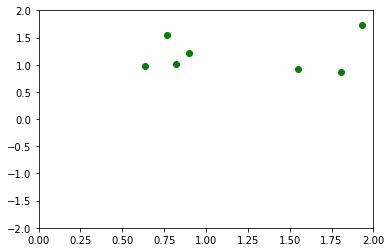

In [5]:
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        #anim._encoded_video = video.encode("base64")
        anim._encoded_video = base64.b64encode(video)
    
    return VIDEO_TAG.format(anim._encoded_video)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = plt.plot([], [],'o',c='green')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = particulas[:,i,0]
    y = particulas[:,i,1]
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

<div id='time' />
## Analisis de tiempo

In [6]:
t1 = %timeit -o -n 10 euler(H,posisiones,masas,velocidades,dt,k)

1.01 s ± 46.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
print("\nTime of all runs:")
print(t1.all_runs)

print("\nBest measured time:")
print(t1.best)

print("\nWorst measured time:")
print(t1.worst)

print("\nCompilation time:")
print(t1.compile_time)


Time of all runs:
[10.049915941999643, 9.789923661999637, 10.198506198998075, 10.406280647999665, 10.714296598001965, 9.237172267996357, 10.50866723999934]

Best measured time:
0.9237172267996356

Worst measured time:
1.0714296598001964

Compilation time:
0.00012799999999835165


<div id='prof' />
## _Profiling_

Procedemos a ver cual es la función que mas tiempo demora, si <code>H()</code> o la función <code>euler()</code>:

In [8]:
%%prun -s cumulative -q -l 15 -T prun0
euler(H,posisiones,masas,velocidades,dt,k)

 
*** Profile printout saved to text file 'prun0'. 


In [9]:
print(open('prun0', 'r').read())

         50106 function calls in 1.066 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.066    1.066 {built-in method builtins.exec}
        1    0.002    0.002    1.066    1.066 <string>:2(<module>)
        1    0.043    0.043    1.064    1.064 <ipython-input-2-521d5fe6e212>:11(euler)
    20000    1.012    0.000    1.014    0.000 <ipython-input-2-521d5fe6e212>:2(H)
        1    0.005    0.005    0.005    0.005 {built-in method numpy.core.multiarray.array}
    20001    0.002    0.000    0.002    0.000 {built-in method builtins.len}
    10100    0.002    0.000    0.002    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


Nos damos cuenta por el _tottime_ que la función que más se demora es <code>H()</code>. Luego procedemos a hacer un __`line_profile`__  de esta función: 

In [10]:
%lprun -T lprof -f H H(posisiones[:,0],posisiones[0][0],masas)


*** Profile printout saved to text file 'lprof'. 


In [11]:
print(open('lprof', 'r').read())

Timer unit: 1e-06 s

Total time: 0.000126 s
File: <ipython-input-2-521d5fe6e212>
Function: H at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def H(posisiones,position_i,masas):
     3         1            3      3.0      2.4      G = 6.67300e-11
     4         1            0      0.0      0.0      sum = 0
     5        51           24      0.5     19.0      for i in range(len(posisiones)):
     6        50           34      0.7     27.0          if (posisiones[i] != position_i):
     7        49           64      1.3     50.8              sum+= masas[i]/((posisiones[i] - position_i)**2)
     8         1            1      1.0      0.8      return G*sum


Nos damos cuenta que la linea que mas demora es la séptima linea. Para optimizar esto usamos _numba_, ademas de restar primero las posiciones y luego eleverlas al cuadrado en vez de hacer este procedimiento en conjunto:

In [12]:
@numba.jit('float64 (float64[:],float64,float64[:])', nopython=True)
def H(posisiones,position_i,masas):
    G = 6.67300e-11
    sum = 0
    for i in range(len(posisiones)):
        if (posisiones[i] != position_i):
            resta = (posisiones[i] - position_i)
            sum+= masas[i]/resta**2
    return G*sum

Procedemos a ver nuevamente _profiling_:

In [13]:
%%prun -s cumulative -q -l 15 -T prun0
euler(H,posisiones,masas,velocidades,dt,k)

 
*** Profile printout saved to text file 'prun0'. 


In [14]:
print(open('prun0', 'r').read())

         30508 function calls (30474 primitive calls) in 0.095 seconds

   Ordered by: cumulative time
   List reduced from 76 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.095    0.095 {built-in method builtins.exec}
        1    0.002    0.002    0.095    0.095 <string>:2(<module>)
        1    0.069    0.069    0.093    0.093 <ipython-input-2-521d5fe6e212>:11(euler)
    20000    0.017    0.000    0.017    0.000 <ipython-input-12-68de84627ce3>:1(H)
        1    0.004    0.004    0.004    0.004 {built-in method numpy.core.multiarray.array}
    10125    0.001    0.000    0.001    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.001    0.001 dispatcher.py:401(_search_new_conversions)
        5    0.000    0.000    0.001    0.000 dispatcher.py:420(typeof_pyval)
        5    0.000    0.000    0.001    0.000 typeof.py:22(typeof)
        5    0.000    0.000    0.001    0.000 f

Nos damos cuenta que claramente por el _tottime_ que el tiempo de <code>H()</code> bajo considerablemente, lo que lleva a que el tiempo total del proceso disminuya bastante. Vemos entonces el tiempo nuevamente de nuestro algoritmo: 

In [15]:
t2 = %timeit -o -n 10 euler(H,posisiones,masas,velocidades,dt,k)

41.2 ms ± 2.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
print("Performance improvement:")
print(t1.best/t2.best)

Performance improvement:
23.982665744925615


Por lo que vemos que el _performance_ de nuestra función mejoró considerablemente.

<div id='con' />
## Conclusión

Podemos observar que así como _numba_, existen diversas formas de poder optimizar nuestro código, como _cython_, paralelizar nuestro proceso, etc. Sin embargo el tiempo alcanzado es bastante prudente para el gran cálculo que se debe hacer por partícula. 

<h1><center>¡Gracias por su atencion! =)</center></h1>

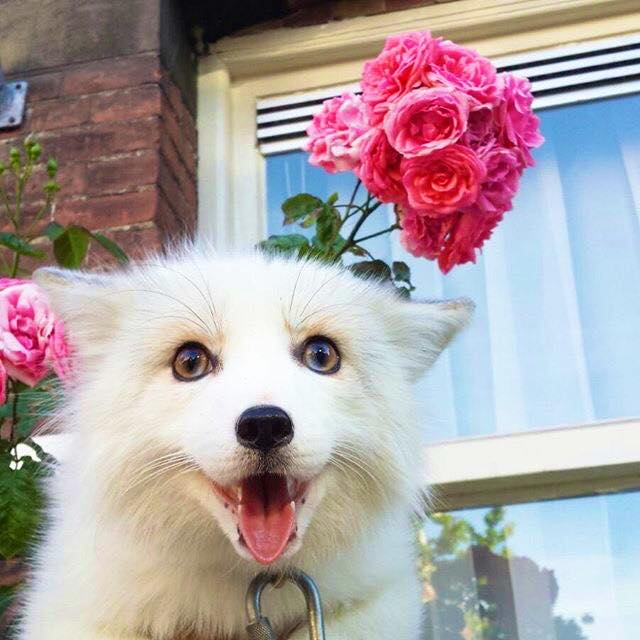

In [5]:
Image(filename='zorro.jpg') 